<a href="https://colab.research.google.com/github/ali-ihssan/Machine-learning-class/blob/main/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM Using PyTorch

The problem you will look at in this post is the international airline passengers prediction problem. This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

It is a regression problem. That is, given the number of passengers (in unit of 1,000) the recent months, what is the number of passengers the next month. The dataset has only one feature: The number of passengers.

Let’s start by reading the data. The data can be downloaded here.

## Download Dataset

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2023-11-30 13:56:50--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv.2’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-11-30 13:56:50 (11.2 MB/s) - ‘airline-passengers.csv.2’ saved [2180/2180]



## Data Load


In [ ]:
import pandas as pd

df = pd.read_csv('airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


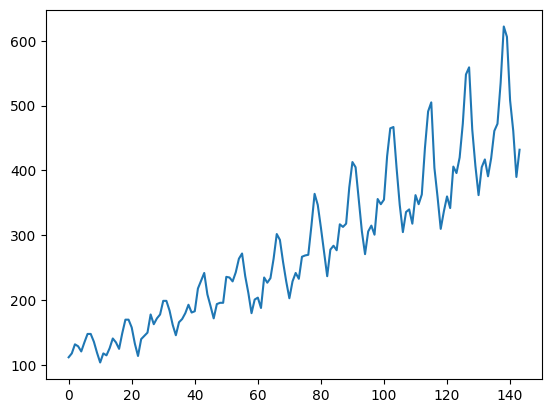

In [ ]:
import matplotlib.pyplot as plt

timeseries = df[["Passengers"]].values

plt.plot(timeseries, label = 'Airline Passangers Data')
plt.show()

# Train, test split
For simplicity, the training set is the first half of time series and the remaining will be used as the test set. This can be easily done on a numpy array.

In [ ]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

Usually time series prediction is done on a window. That is, given data from time to time, you are asked to predict for time (or deeper into the future). The size of window governs how much data you are allowed to look at when you make the prediction. This is also called the look back period.

In [ ]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).type(torch.FloatTensor), torch.tensor(y).type(torch.FloatTensor)

It is intentional to produce the “feature” and the “target” the same shape: For a window of three time steps, the “feature” is the time series from t to t+2 and the target is from t+1 to t+3. What we are interested is
t+3 but the information of t+1 to t+2 is useful in training.

In [ ]:
import torch

lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


## Model

In [ ]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)


In [ ]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 226.3217, test RMSE 422.7252
Epoch 100: train RMSE 188.6414, test RMSE 383.3461
Epoch 200: train RMSE 158.5441, test RMSE 351.0590
Epoch 300: train RMSE 129.8493, test RMSE 318.8889
Epoch 400: train RMSE 106.0935, test RMSE 289.9464
Epoch 500: train RMSE 87.6399, test RMSE 264.1733
Epoch 600: train RMSE 71.4705, test RMSE 239.6740
Epoch 700: train RMSE 58.1632, test RMSE 216.6513
Epoch 800: train RMSE 47.7937, test RMSE 195.9740
Epoch 900: train RMSE 40.7674, test RMSE 177.0967
Epoch 1000: train RMSE 34.1545, test RMSE 161.0228
Epoch 1100: train RMSE 30.3593, test RMSE 147.1461
Epoch 1200: train RMSE 27.9189, test RMSE 135.9677
Epoch 1300: train RMSE 26.3608, test RMSE 126.7403
Epoch 1400: train RMSE 25.2266, test RMSE 119.5006
Epoch 1500: train RMSE 24.7402, test RMSE 113.2249
Epoch 1600: train RMSE 24.2566, test RMSE 109.4606
Epoch 1700: train RMSE 24.0299, test RMSE 104.9833
Epoch 1800: train RMSE 24.0781, test RMSE 101.4279
Epoch 1900: train RMSE 23.5053, test R

# Results

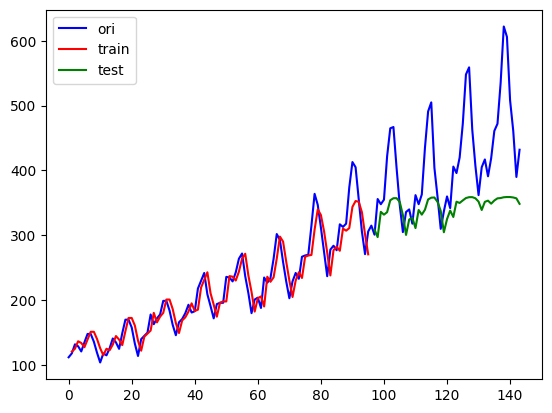

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b', label='ori')
plt.plot(train_plot, c='r', label='train')
plt.plot(test_plot, c='g', label='test')
plt.legend()
plt.show()

# Improve the performance

You can see from the plot that there is an upward trend. There are also some periodicity in the dataset that corresponds to the summer holiday period in the northern hemisphere. Usually a time series should be “detrended” to remove the linear trend component and normalized before processing.

## MinMax Scaler to remove the linear trend component and normalized


In [ ]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
sc.fit(timeseries)
train = sc.fit_transform(train)
test = sc.fit_transform(test)


In [ ]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


In [ ]:
model = AirModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)


In [ ]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.4485, test RMSE 0.4524
Epoch 100: train RMSE 0.0751, test RMSE 0.1477
Epoch 200: train RMSE 0.0743, test RMSE 0.1469
Epoch 300: train RMSE 0.0739, test RMSE 0.1463
Epoch 400: train RMSE 0.0743, test RMSE 0.1469
Epoch 500: train RMSE 0.0737, test RMSE 0.1465
Epoch 600: train RMSE 0.0741, test RMSE 0.1462
Epoch 700: train RMSE 0.0737, test RMSE 0.1465
Epoch 800: train RMSE 0.0736, test RMSE 0.1463
Epoch 900: train RMSE 0.0738, test RMSE 0.1465
Epoch 1000: train RMSE 0.0736, test RMSE 0.1465
Epoch 1100: train RMSE 0.0738, test RMSE 0.1469
Epoch 1200: train RMSE 0.0736, test RMSE 0.1464
Epoch 1300: train RMSE 0.0738, test RMSE 0.1466
Epoch 1400: train RMSE 0.0739, test RMSE 0.1463
Epoch 1500: train RMSE 0.0736, test RMSE 0.1467
Epoch 1600: train RMSE 0.0740, test RMSE 0.1463
Epoch 1700: train RMSE 0.0742, test RMSE 0.1464
Epoch 1800: train RMSE 0.0736, test RMSE 0.1464
Epoch 1900: train RMSE 0.0736, test RMSE 0.1464


In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

train_plot = sc.inverse_transform(train_plot)
test_plot = sc.inverse_transform(test_plot)

# plot
plt.plot(timeseries, c='b', label='ori')
plt.plot(train_plot, c='r', label='train')
plt.plot(test_plot, c='g', label='test')
plt.legend()
plt.show()

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        # self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

## Training

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

NameError: ignored

## Testing for Airplane Passengers Dataset

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

# References:
1. This lab is adopted from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
2. For Language Modeling with LSTMs in PyTorch - https://towardsdatascience.com/language-modeling-with-lstms-in-pytorch-381a26badcbf
3. For time series forecasting - https://medium.com/@ozdogar/time-series-forecasting-using-lstm-pytorch-implementation-86169d74942e